In [416]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import matplotlib as mpl
import random
from datetime import timedelta
from numba import njit
import glob
from scipy.interpolate import interp1d


import warnings
warnings.filterwarnings('ignore')

In [109]:
import matplotlib.dates as mdates
def set_date_axis_fmt(ax):
    # Set the locator
    locator = mdates.MonthLocator()  # every month
    # Specify the format
    fmt = mdates.DateFormatter('%b %y')

    X = ax.xaxis
    X.set_major_locator(locator)
    # Specify formatter
    X.set_major_formatter(fmt)
 

In [9]:
# download surveillance data

incidence = True
target_obs = 'hospitalization'
observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])
observations = observations.drop(columns=['Unnamed: 0', 'weekly_rate'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())
observations = observations[(observations['date'] >= start_week) & \
                                (observations['date'] <= max_date)]

   
#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)


In [10]:
observations

,location,date,value
0,01,2023-09-09,5
1,45,2023-09-09,22
2,16,2023-09-09,2
3,46,2023-09-09,3
4,15,2023-09-09,5
...,...,...,...
1797,72,2024-04-27,44
1798,35,2024-04-27,20
1799,19,2024-04-27,22
1800,55,2024-04-27,38


In [12]:
obs = observations[observations.location=='US']

In [395]:

# get observations
def historical_truths(issue_date='2024-08-01', spatial_resolution=['state'], temporal_resolution='weekly'):
    # Load historical COVID-19 data
    data = load_covid_data()

    # Filter by spatial resolution
    if 'state' in spatial_resolution:
        # Assuming we only have state-level data for now
        pass

    # Convert date column to datetime
    data['date'] = pd.to_datetime(data['date'])

    # Filter data up to the issue_date
    issue_date = pd.to_datetime(issue_date)
    data = data[data['date'] <= issue_date]

    # Resample to weekly data if temporal_resolution is 'weekly'
    if temporal_resolution == 'weekly':
        data = data.set_index('date').groupby('location').resample('W-Sun').agg({
            'cum_deaths': 'max',  # Assuming cumulative deaths should take the maximum value of the week
            'inc_deaths': 'sum'   # Summing incident deaths over the week
        }).reset_index()

    return data

class QuantileBaseline:
    def __init__(self, inc_diffs, symmetrize=True):
        self.inc_diffs = inc_diffs
        self.symmetrize = symmetrize
      #  if self.symmetrize:
       #     self.symmetrize_diffs()

   # def symmetrize_diffs(self):
    #    self.inc_diffs = np.concatenate((self.inc_diffs, -self.inc_diffs))

def fit_quantile_baseline(incidence,target, symmetrize=True, window_size=None):
    if window_size is None:
        window_size = len(incidence) - 1
    if window_size >= len(incidence):
        window_size = len(incidence) - 1

    diffs = np.diff(incidence['value'])[-window_size:]
    diffs = diffs[~np.isnan(diffs)]
    
    if symmetrize:
        inc_diffs = list(diffs) + [-x for x in diffs]
    else:
        inc_diffs = list(diffs)

    return QuantileBaseline(inc_diffs=np.array(inc_diffs), symmetrize=symmetrize)



In [397]:
# generate baseline model

quantiles = [0.01, 0.025] + list(np.arange(0.05, 0.96, 0.05)) + [0.975, 0.99]
horizon = 4
num_samples = 100000


incidence = True
target_obs = 'hospitalization'
observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])
observations = observations.drop(columns=['Unnamed: 0', 'weekly_rate'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())
#observations = observations[(observations['date'] >= start_week) & \
 #                               (observations['date'] <= max_date)]

observations = observations[(observations['date'] <= max_date) & (observations['date'] >= pd.to_datetime('2022-09-01'))]

   
#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)


target = 'inc hosp'
# Generate forecast week end dates
#forecast_week_end_dates = [(start_date + timedelta(days=i*7)).strftime('%Y-%m-%d') for i in range(-5, 7)]
forecast_week_end_dates = [num for num in observations['date'].unique() if num >= pd.to_datetime('2023-09-01')]

#forecast_week_end_dates = [num for num in observations['date'].unique() if num >= pd.to_datetime('2022-09-01')]

results_list = []

baseline_model = pd.DataFrame()
for forecast_week_end_date in forecast_week_end_dates:
    data = observations.copy()
    
    if len(data)==0:
        continue
    
    unique_locations = data['location'].unique()
    
    for location in unique_locations:
    
        location_data = data[data['location'] == location]
        
        location_data = location_data[location_data['date'] <= forecast_week_end_date]
        
        baseline_fit = fit_quantile_baseline(incidence=location_data,target=target, symmetrize=True, 
                                             window_size=None)


        ########### Predict function #############
        inc_data = location_data['value']

        last_observed_value = inc_data.iloc[-1]
        #print(last_observed_value)
        #inc_predictions = np.cumsum(samples, axis=1) + last_observed_value

        # Compute quantiles
        #predictions = np.quantile(inc_predictions, quantiles, axis=0)

        sampled_inc_diffs = np.quantile(baseline_fit.inc_diffs, np.linspace(0, 1, num_samples))

        # Ensure the median difference is 0
        median_diff = np.median(sampled_inc_diffs)
        sampled_inc_diffs -= median_diff

        # Compute the raw sampled incidence values
        sampled_inc_raw = last_observed_value + sampled_inc_diffs

        # Enforce non-negative incidence
        sampled_inc_raw = np.maximum(sampled_inc_raw, 0)


        #samples = np.tile(sampled_inc_raw, (horizon, 1)).T.cumsum(axis=1)
        predictions = np.quantile(sampled_inc_raw, quantiles, axis=0)
        
        #save first horizon
        results = pd.DataFrame({'horizon':1, 'forecast_date':pd.to_datetime(forecast_week_end_date),
                                'target_end_date': pd.to_datetime(forecast_week_end_date) + timedelta(weeks=1)  ,
                                'target':'inc hosp','location':location ,'quantile':quantiles, 'value':predictions})
        
        baseline_model = pd.concat([baseline_model, results])
        
        for h in list(range(2, horizon+1)):
            
            # Sample differences again for new horizon
            sampled_inc_diffs = np.random.choice(sampled_inc_diffs, size=num_samples, replace=True)
            sampled_inc_raw = sampled_inc_raw + sampled_inc_diffs

            # Adjust incidence if symmetrize is TRUE
            if symmetrize:
                sampled_inc_corrected = sampled_inc_raw - (np.median(sampled_inc_raw) - last_observed_value)
            else:
                sampled_inc_corrected = sampled_inc_raw

            # Ensure non-negative incidence
            sampled_inc_corrected = np.maximum(sampled_inc_corrected, 0)

            
            
            predictionshorizon = np.quantile(sampled_inc_corrected, quantiles, axis=0)
        
            resultshorizon = pd.DataFrame({'horizon':h, 'forecast_date':pd.to_datetime(forecast_week_end_date),
                                           'target_end_date':pd.to_datetime(forecast_week_end_date) + timedelta(weeks=1*h),
                                           'target':'inc hosp','location':location , 'quantile':quantiles, 
                                    'value':predictionshorizon})
        
            baseline_model = pd.concat([baseline_model, resultshorizon])
        
        
        
baseline_model['quantile'] = baseline_model['quantile'].round(2)         
        
        
        


In [398]:
baseline_model.to_pickle('../fludat/baseline_model_flu23-24.pkl')

In [399]:
baseline_model

,horizon,forecast_date,target_end_date,target,location,quantile,value
0,1,2023-09-02,2023-09-09,inc hosp,01,0.01,0.000000
1,1,2023-09-02,2023-09-09,inc hosp,01,0.02,0.000000
2,1,2023-09-02,2023-09-09,inc hosp,01,0.05,0.000000
3,1,2023-09-02,2023-09-09,inc hosp,01,0.10,0.000000
4,1,2023-09-02,2023-09-09,inc hosp,01,0.15,0.000000
...,...,...,...,...,...,...,...
18,4,2024-04-27,2024-05-25,inc hosp,34,0.85,220.431833
19,4,2024-04-27,2024-05-25,inc hosp,34,0.90,257.708100
20,4,2024-04-27,2024-05-25,inc hosp,34,0.95,318.730897
21,4,2024-04-27,2024-05-25,inc hosp,34,0.98,381.879435


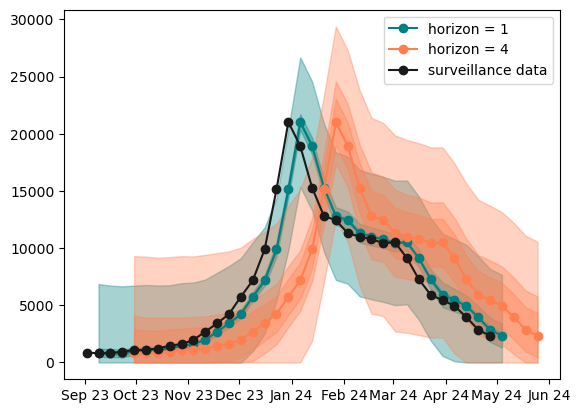

In [402]:
# plot 1 and 4-week-ahead baseline model forecasts for the 2023-24 flu season

quants = [(0.02,0.98),(.15, .85),(0.25,0.75)]
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1

fig, ax = plt.subplots(1,1)

observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])
observations = observations.drop(columns=['Unnamed: 0', 'weekly_rate'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())
#observations = observations[(observations['date'] >= start_week) & \
 #                               (observations['date'] <= max_date)]

observations = observations[(observations['date'] <= max_date) & (observations['date'] >= pd.to_datetime('2022-09-01'))]

   
#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)



#horizon = 1
colors = ['teal', 'coral']
location='US'
i=0
for horizon in [1,4]:
    for q in quants:
        df = baseline_model[ (baseline_model.horizon==horizon)&\
                          (baseline_model.location == location)]

        qupp = baseline_model[(baseline_model['quantile']==q[0]) & (baseline_model.horizon==horizon)&\
                          (baseline_model.location == location)].value
        qlow = baseline_model[(baseline_model['quantile']==q[1]) & (baseline_model.horizon==horizon) &\
                          (baseline_model.location == location)].value

        plt.fill_between(df.target_end_date.unique(),qupp,qlow, color=colors[i], alpha=alpha)

    qmed = baseline_model[(baseline_model['quantile']==0.5) & (baseline_model.horizon==horizon) &\
                          (baseline_model.location == location)].value

    plt.plot(df.target_end_date.unique(),qmed,'-o', color=colors[i], alpha=1, label='horizon = '+ str(horizon))
    
    i+=1

set_date_axis_fmt(ax)
    
observations['date'] = pd.to_datetime(observations['date'])
observations = observations[(observations.location==location) & (observations.date>=pd.to_datetime('2023-09-01')) ]


plt.plot(observations.date,observations.value, '-o', color='#1a1a1a', label = 'surveillance data')
   
plt.legend()

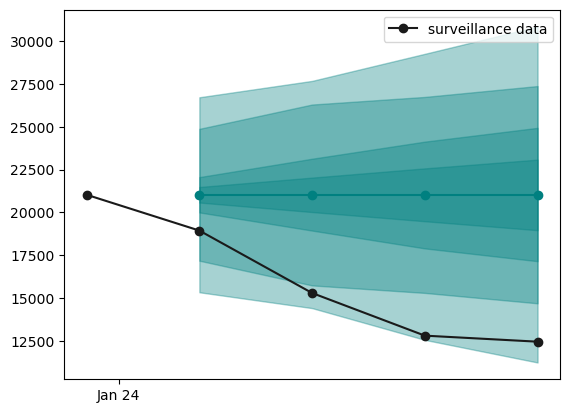

In [361]:
# 1-4 week ahead forecasts made at a given forecast date

quants = [(0.01,0.99),(0.05,0.95),(.15, .85),(0.25,0.75)]
map_alpha = lambda interval_range: 0.5 * (1-interval_range) + 0.1

fig, ax = plt.subplots(1,1)

#horizon = 1
colors = ['teal', 'coral']
location='US'
i=0

for q in quants:
    df = baseline_model[ (baseline_model.forecast_date==pd.to_datetime('2023-12-30'))&\
                      (baseline_model.location == location)]

    qupp = baseline_model[(baseline_model['quantile']==q[0]) & (baseline_model.forecast_date==pd.to_datetime('2023-12-30'))&\
                      (baseline_model.location == location)].value
    qlow = baseline_model[(baseline_model['quantile']==q[1]) & (baseline_model.forecast_date==pd.to_datetime('2023-12-30')) &\
                      (baseline_model.location == location)].value

    plt.fill_between(df.target_end_date.unique(),qupp,qlow, color=colors[i], alpha=alpha)

qmed = baseline_model[(baseline_model['quantile']==0.5) & (baseline_model.forecast_date==pd.to_datetime('2023-12-30')) &\
                      (baseline_model.location == location)].value

plt.plot(df.target_end_date.unique(),qmed,'-o', color=colors[i], alpha=1)

i+=1

set_date_axis_fmt(ax)
    
observations = observations[(observations.location==location) ]
observations['date'] = pd.to_datetime(observations['date'])
observations = observations[(observations.date>=pd.to_datetime('2023-12-30'))&\
                            (observations.date<=pd.to_datetime('2024-01-27'))]

plt.plot(observations.date,observations.value, '-o', color='#1a1a1a', label = 'surveillance data')
   
plt.legend()

In [377]:
baseline_model

,horizon,forecast_date,target_end_date,target,location,quantile,value
0,1,2023-09-02,2023-09-09,inc hosp,US,0.01,0.000000
1,1,2023-09-02,2023-09-09,inc hosp,US,0.02,0.000000
2,1,2023-09-02,2023-09-09,inc hosp,US,0.05,0.000000
3,1,2023-09-02,2023-09-09,inc hosp,US,0.10,0.000000
4,1,2023-09-02,2023-09-09,inc hosp,US,0.15,506.350000
...,...,...,...,...,...,...,...
18,4,2024-04-27,2024-05-25,inc hosp,US,0.85,5842.382693
19,4,2024-04-27,2024-05-25,inc hosp,US,0.90,7326.029835
20,4,2024-04-27,2024-05-25,inc hosp,US,0.95,9214.748474
21,4,2024-04-27,2024-05-25,inc hosp,US,0.98,10556.870489


In [ ]:
# Generate trajectories from 4 week ahead baseline model

In [407]:
df = baseline_model[(baseline_model.location=='US') & (baseline_model.horizon==4)]

In [453]:
# Generate trajectories
def generate_trajectories(time_points, quantiles, num_trajectories):
    # Create the CDF interpolation function for each time point
    #quantile_values = np.array(list(quantiles.values()))
   # quantile_levels = np.array(list(quantiles.keys()))
    trajectories = []

    for _ in range(num_trajectories):
        trajectory = []
        for t in range(len(time_points)):
            
            quantile_values = np.array(df[df.target_end_date==time_points[t]].value)
            quantile_levels = np.array(df[df.target_end_date==time_points[t]]['quantile'])
            # Interpolate to get the CDF at this time point
            cdf_interp = interp1d(quantile_levels, quantile_values, kind='linear', fill_value="extrapolate")
            
            # Generate a random sample from the interpolated CDF
            u = np.random.uniform(0, 1)
            sample = cdf_interp(u)
            trajectory.append(sample)
        trajectories.append(trajectory)

    return np.array(trajectories)

# Generate 100 random trajectories
num_trajectories = 100
trajectoriesdf = pd.DataFrame()
for location in baseline_model.location.unique():
    df = baseline_model[(baseline_model.location==location) & (baseline_model.horizon==4)]
    
    time_points = df.target_end_date.unique()
    trajectories = generate_trajectories(time_points, quantiles, num_trajectories)

    for i in range(len(trajectories)):
        new = pd.DataFrame({'location':location,'horizon':4 ,'date':time_points, 'value':trajectories[i], 
                           'trajectory_id':i})

        trajectoriesdf = pd.concat([trajectoriesdf, new])

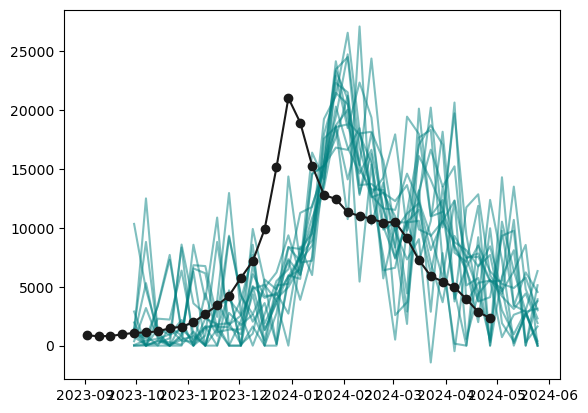

In [444]:
for i in range(len(trajectories)):
    plt.plot(time_points, trajectories[i], color='teal', alpha=.5)
    
observations['date'] = pd.to_datetime(observations['date'])
observations = observations[(observations.location==location) & (observations.date>=pd.to_datetime('2023-09-01')) ]


plt.plot(observations.date,observations.value, '-o', color='#1a1a1a', label = 'surveillance data')


In [460]:
# generate trajectories by sampling from the distribution of historical differences

quantiles = [0.01, 0.025] + list(np.arange(0.05, 0.96, 0.05)) + [0.975, 0.99]
horizon = 4
num_samples = 100


incidence = True
target_obs = 'hospitalization'
observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])
observations = observations.drop(columns=['Unnamed: 0', 'weekly_rate'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())
#observations = observations[(observations['date'] >= start_week) & \
 #                               (observations['date'] <= max_date)]

observations = observations[(observations['date'] <= max_date) & (observations['date'] >= pd.to_datetime('2022-09-01'))]

   
#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)


target = 'inc hosp'
# Generate forecast week end dates
#forecast_week_end_dates = [(start_date + timedelta(days=i*7)).strftime('%Y-%m-%d') for i in range(-5, 7)]
forecast_week_end_dates = [num for num in observations['date'].unique() if num >= pd.to_datetime('2023-09-01')]

#forecast_week_end_dates = [num for num in observations['date'].unique() if num >= pd.to_datetime('2022-09-01')]

results_list = []

baseline_model = pd.DataFrame()

for forecast_week_end_date in forecast_week_end_dates:
    data = observations.copy()
    
    if len(data)==0:
        continue
    
    unique_locations = data['location'].unique()
    
    for location in unique_locations:
    
        location_data = data[data['location'] == location]
        
        location_data = location_data[location_data['date'] <= forecast_week_end_date]
        
        baseline_fit = fit_quantile_baseline(incidence=location_data,target=target, symmetrize=True, 
                                             window_size=None)


        ########### Predict function #############
        inc_data = location_data['value']

        last_observed_value = inc_data.iloc[-1]
        #print(last_observed_value)
        #inc_predictions = np.cumsum(samples, axis=1) + last_observed_value

        # Compute quantiles
        #predictions = np.quantile(inc_predictions, quantiles, axis=0)

        sampled_inc_diffs = np.quantile(baseline_fit.inc_diffs, np.linspace(0, 1, num_samples))

        # Ensure the median difference is 0
        median_diff = np.median(sampled_inc_diffs)
        sampled_inc_diffs -= median_diff

        # Compute the raw sampled incidence values
        sampled_inc_raw = last_observed_value + sampled_inc_diffs

        # Enforce non-negative incidence
        sampled_inc_raw = np.maximum(sampled_inc_raw, 0)


        #samples = np.tile(sampled_inc_raw, (horizon, 1)).T.cumsum(axis=1)
       # predictions = np.quantile(sampled_inc_raw, quantiles, axis=0)
        
        #save first horizon
        results = pd.DataFrame({'horizon':1, 'forecast_date':pd.to_datetime(forecast_week_end_date),
                                'target_end_date': pd.to_datetime(forecast_week_end_date) + timedelta(weeks=1)  ,
                                'target':'inc hosp','location':location ,'trajectory_id':list(range(100)), 
                                'value':sampled_inc_raw})
        
        baseline_model = pd.concat([baseline_model, results])
        
        for h in list(range(2, horizon+1)):
            
            # Sample differences again for new horizon
            sampled_inc_diffs = np.random.choice(sampled_inc_diffs, size=num_samples, replace=True)
            sampled_inc_raw = sampled_inc_raw + sampled_inc_diffs

            # Adjust incidence if symmetrize is TRUE
            if symmetrize:
                sampled_inc_corrected = sampled_inc_raw - (np.median(sampled_inc_raw) - last_observed_value)
            else:
                sampled_inc_corrected = sampled_inc_raw

            # Ensure non-negative incidence
            sampled_inc_corrected = np.maximum(sampled_inc_corrected, 0)

            
            
            #predictionshorizon = np.quantile(sampled_inc_corrected, quantiles, axis=0)
        
            resultshorizon = pd.DataFrame({'horizon':h, 'forecast_date':pd.to_datetime(forecast_week_end_date),
                                           'target_end_date':pd.to_datetime(forecast_week_end_date) + timedelta(weeks=1*h),
                                           'target':'inc hosp','location':location , 'trajectory_id':list(range(100)), 
                                    'value':sampled_inc_corrected})
        
            baseline_model = pd.concat([baseline_model, resultshorizon])
        
   
        
#baseline_model['quantile'] = baseline_model['quantile'].round(2)         
        
        


In [461]:
baseline_model

,horizon,forecast_date,target_end_date,target,location,trajectory_id,value
0,1,2023-09-02,2023-09-09,inc hosp,01,0,0.000000
1,1,2023-09-02,2023-09-09,inc hosp,01,1,0.000000
2,1,2023-09-02,2023-09-09,inc hosp,01,2,0.000000
3,1,2023-09-02,2023-09-09,inc hosp,01,3,0.000000
4,1,2023-09-02,2023-09-09,inc hosp,01,4,0.000000
...,...,...,...,...,...,...,...
95,4,2024-04-27,2024-05-25,inc hosp,34,95,303.181818
96,4,2024-04-27,2024-05-25,inc hosp,34,96,324.090909
97,4,2024-04-27,2024-05-25,inc hosp,34,97,372.454545
98,4,2024-04-27,2024-05-25,inc hosp,34,98,288.000000


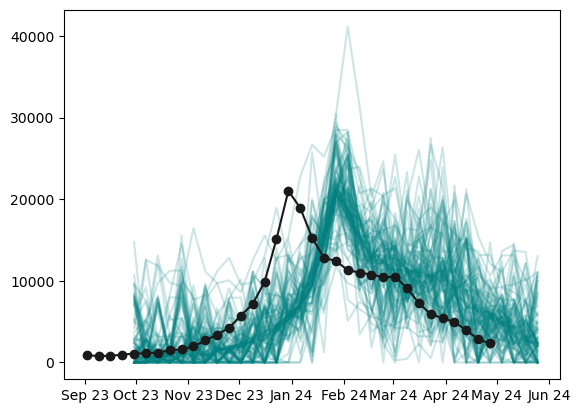

In [469]:
# plot baseline model trajectories

observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
observations['date'] = pd.to_datetime(observations['date'])
observations = observations.drop(columns=['Unnamed: 0', 'weekly_rate'])

start_week = pd.to_datetime('2023-09-09')
max_date = pd.to_datetime(observations.date.max())
#observations = observations[(observations['date'] >= start_week) & \
 #                               (observations['date'] <= max_date)]

observations = observations[(observations['date'] <= max_date) & (observations['date'] >= pd.to_datetime('2022-09-01'))]

   
#aggregate to weekly
observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

#transform to Observation object
observations = Observations(observations)

fig,ax = plt.subplots(1,1)

df = baseline_model[(baseline_model.location=='US') & (baseline_model.horizon==4)]
for i in df.trajectory_id.unique():
    plt.plot(df.target_end_date.unique(), df[df.trajectory_id==i].value, color='teal', alpha=.2)
    
observations['date'] = pd.to_datetime(observations['date'])
observations = observations[(observations.location=='US') & (observations.date>=pd.to_datetime('2023-09-01')) ]


plt.plot(observations.date,observations.value, '-o', color='#1a1a1a', label = 'surveillance data')

set_date_axis_fmt(ax)

In [485]:
# calculate energy score for flu baseline model from trajectories

from numba import njit
@njit
def energyscore(X,y):
    # X is matrix of trajectories, y is observations
    ES = 0
    N = X.shape[0]
    for i in range(N):
        ES += np.sqrt(np.sum((X[i]-y)**2))/N
    for i in range(N):
        for j in range(N):
            ES -= np.sqrt(np.sum((X[i]-X[j])**2))/(2*N**2)
    return ES


baselinedf = baseline_model[baseline_model.horizon==4]

energyscoresdf = pd.DataFrame()

for location in baselinedf.location.unique():
    
    observations = pd.read_parquet(f"/Users/bay.c/Documents/GitHub/energy-score/fludat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    dffilt = baselinedf[baselinedf.location==location]
    
    
    if len(dffilt) == 0:
        print(f'no predictions  at location {loc} ')
        continue

    observations = observations[(observations['date'] >= dffilt.target_end_date.min()) & \
                                (observations['date'] <= dffilt.target_end_date.max())]   


    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    #transform to Observation object
    observations = Observations(observations)

    #filter location
    observations = observations[observations['location'] == location]

    dffilt = dffilt[dffilt.target_end_date <= observations.date.max()]

    y = np.array(observations.value)
    X = [np.array(dffilt[dffilt['trajectory_id'] == i].value) for i in dffilt['trajectory_id'].unique()]

    ES = energyscore(np.array(X),y)



    newrow = pd.DataFrame({'Model':'flu-baseline','location':location, 
                        'target':'inc hosp', 'horizon':4, 'energyscore':ES, }, index=[0])

    energyscoresdf = pd.concat([energyscoresdf, newrow])


energyscoresdf = energyscoresdf.reset_index()
energyscoresdf = energyscoresdf.drop(columns=['index'])   




In [486]:
energyscoresdf

,Model,location,target,horizon,energyscore
0,flu-baseline,01,inc hosp,4,399.615869
1,flu-baseline,53,inc hosp,4,251.603242
2,flu-baseline,23,inc hosp,4,88.421476
3,flu-baseline,21,inc hosp,4,352.721981
4,flu-baseline,30,inc hosp,4,180.588005
5,flu-baseline,38,inc hosp,4,54.442272
6,flu-baseline,22,inc hosp,4,433.495601
7,flu-baseline,39,inc hosp,4,805.943063
8,flu-baseline,11,inc hosp,4,74.162720
9,flu-baseline,50,inc hosp,4,34.531526


In [487]:
energyscoresdf.to_pickle('../fludat/flu-baseline_energyscore.pkl')